In [1]:
# TODO
# Data Aug
# Progressive Resizing
# TTA
# Ablumations
# Remove background and noise
# Find image mean, std (whole dataset)
# One Batch
# Crop and resize
# https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
# Early Stopping
# Telegram to transfer the images (LR Curve)
# Send the best epoch number
# Add GPU monitoring

# https://mc.ai/1st-place-solution-for-intel-scene-classification-challenge/
# https://www.kaggle.com/c/aptos2019-blindness-detection/discussion/108030
# https://github.com/lukemelas/EfficientNet-PyTorch
# https://github.com/DrHB/APTOS-2019-GOLD-MEDAL-SOLUTION
# https://www.kaggle.com/c/airbus-ship-detection/discussion/71664
# https://github.com/pudae/kaggle-understanding-clouds
# https://docs.fast.ai/data_block.html#ItemList.split_from_df
# https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai2.vision.all import *
from efficientnet_pytorch import EfficientNet

In [4]:
np.random.seed(1773)
exp_time = str(datetime.now().replace(second=0, microsecond=0)).replace(" ", "_")

In [5]:
md_ef =  EfficientNet.from_pretrained('efficientnet-b7', num_classes=3)

Loaded pretrained weights for efficientnet-b7


In [6]:
path = '/home/ubuntu/crop/data_v1/train'

In [7]:
df = pd.read_csv("/home/ubuntu/crop/notebooks/fastai2/Prod/cv1.csv")

In [8]:
exp_name = "data-aug"
bs = 64
size = 128

In [9]:
csv_file_name = "{}_{}_{}_{}".format(bs, size, exp_time, exp_name)

In [10]:
item_tfms = RandomResizedCrop(size, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [Rotate(), Flip(), Dihedral()]
dls = ImageDataLoaders.from_df(df=df, path="/home/ubuntu/crop/data_v3/train", item_tfms=item_tfms,
                               batch_tfms=batch_tfms, bs=bs, num_workers=8, device=1)

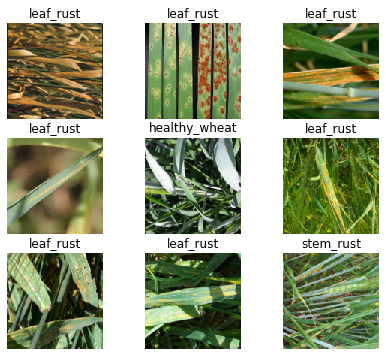

In [11]:
dls.show_batch(max_n=9, figsize=(7,6))

In [12]:
opt_func = partial(ranger, mom=0.9, sqr_mom=0.99, eps=1e-6, beta=0.)
learn = Learner(dls, md_ef, metrics=[error_rate, accuracy], opt_func=opt_func, cbs= MixUp()).to_fp16()

In [13]:
learn.load("128_64_2020-02-29_22:10:00_data-aug")

(0.002754228748381138, 0.005248074419796467)

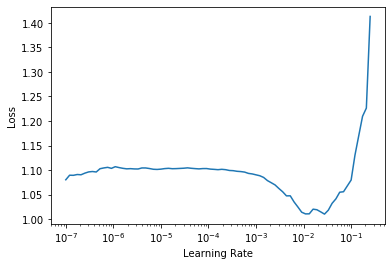

In [14]:
learn.lr_find(suggestions=True)

In [1]:
?SaveModelCallback

Object `SaveModelCallback` not found.


In [15]:
learn.fit_sgdr(5, 3, 1e-3, cbs=[SaveModelCallback(fname=csv_file_name), EarlyStoppingCallback(patience=3)])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.100927,1.087672,0.571429,0.428571,00:30
1,1.082137,1.067744,0.531429,0.468571,00:30
2,1.062606,1.061250,0.548571,0.451429,00:30
3,1.027815,0.994879,0.445714,0.554286,00:31
4,0.968009,0.939710,0.417143,0.582857,00:31
5,0.894037,0.876858,0.365714,0.634286,00:32
6,0.828422,0.805651,0.308571,0.691429,00:30
7,0.774134,0.795484,0.285714,0.714286,00:33
8,0.734799,0.786241,0.291429,0.708571,00:31
9,0.689640,0.757774,0.297143,0.702857,00:30


No improvement since epoch 22: early stopping


(3.6307804407442747e-08, 6.309573450380412e-07)

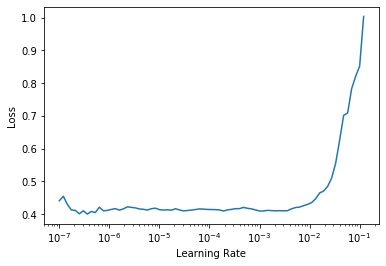

In [16]:
learn.unfreeze()
learn.lr_find(suggestions=True)

In [17]:
learn.fit_sgdr(5, 3, slice(2e-7, 1e-4), cbs=[SaveModelCallback(fname=csv_file_name), EarlyStoppingCallback(patience=3)])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.399767,0.529471,0.211429,0.788571,00:30
1,0.410895,0.519977,0.194286,0.805714,00:33
2,0.417226,0.514143,0.188571,0.811429,00:33
3,0.403465,0.505109,0.182857,0.817143,00:31
4,0.402043,0.501988,0.177143,0.822857,00:31
5,0.399538,0.500544,0.188571,0.811429,00:31
6,0.403168,0.499001,0.188571,0.811429,00:32
7,0.400188,0.497262,0.188571,0.811429,00:32
8,0.396646,0.496775,0.182857,0.817143,00:34
9,0.386547,0.491366,0.177143,0.822857,00:32


No improvement since epoch 9: early stopping


(3.0199518619156154e-08, 2.5118865210060903e-07)

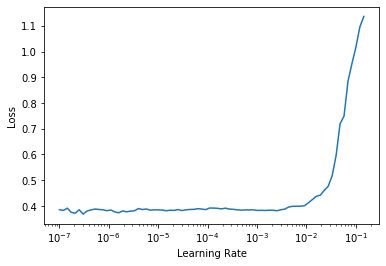

In [18]:
learn.freeze()
learn.lr_find(suggestions=True)

In [19]:
learn.fit_sgdr(5, 3, 1e-3, cbs=[SaveModelCallback(fname=csv_file_name), EarlyStoppingCallback(patience=10)])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.415921,0.494833,0.205714,0.794286,00:31
1,0.392916,0.500985,0.200000,0.800000,00:33
2,0.392029,0.503059,0.200000,0.800000,00:30
3,0.395074,0.502931,0.211429,0.788571,00:31
4,0.396839,0.505022,0.200000,0.800000,00:31
5,0.408641,0.480654,0.182857,0.817143,00:31
6,0.408458,0.467481,0.177143,0.822857,00:33
7,0.399996,0.463951,0.171429,0.828571,00:32
8,0.397623,0.463906,0.171429,0.828571,00:33
9,0.397555,0.521536,0.211429,0.788571,00:30


No improvement since epoch 8: early stopping


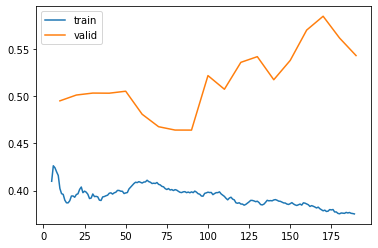

In [20]:
learn.recorder.plot_loss()

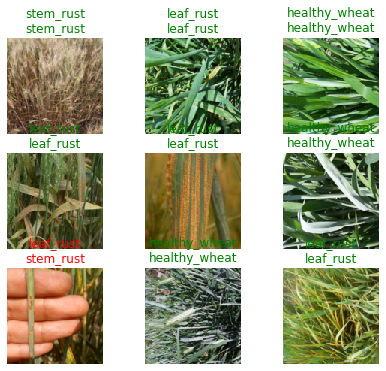

In [21]:
learn.show_results(figsize=(7,6))

[('leaf_rust', 'stem_rust', 15), ('stem_rust', 'leaf_rust', 11)]

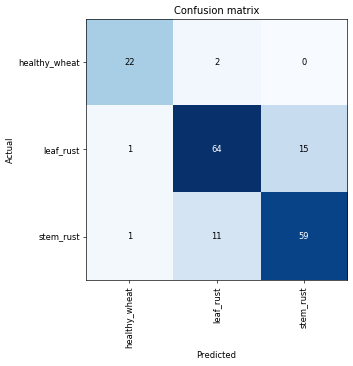

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,6), dpi=60)
interp.most_confused(min_val=10)

In [23]:
path = "/home/ubuntu/crop/data_v1/test"
imgs = get_image_files(path)
test_dl = dls.test_dl(imgs)
preds, _ = learn.get_preds(dl=test_dl) 
ids = [i.split(".")[0] for i in os.listdir('/home/ubuntu/crop/data_v1/test')]
submission = pd.DataFrame({'ID': ids, 'leaf_rust': preds[:,0], 'stem_rust': preds[:,1], 'healthy_wheat': preds[:,2]})

In [24]:
for i, c in enumerate(dls.vocab):
    submission[c] = preds[:,i]

In [25]:
submission.to_csv('/home/ubuntu/crop/submission/'+csv_file_name+'.csv', index=False)

In [26]:
# 0.527501693444374

In [27]:
csv_file_name

'64_128_2020-02-29_23:03:00_data-aug'